In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np

import czifile
from pathlib import Path
import os
from skimage import morphology, exposure, filters
from skimage.feature import canny
from skimage.measure import regionprops, regionprops_table, label
from scipy import ndimage, misc

In [2]:
# replace with a configuration file
work_dir = '/Users/robinhood/Dropbox (HMS)/Data/imaging/processing_test'
filename = 'sfmbt_20210926_5.czi'
channel_dict = {'DAPI': 0, 'TL':1, 'gt':2, 'pho':3, 'hb':4}
bkgd_signal = 200
channel_list = ['DAPI', 'gt', 'pho', 'hb'] #keep for iteration
shape_channel = 'DAPI'
ap_channel = 'DAPI'


In [3]:
directory = work_dir
os.chdir(work_dir)
path = os.path.join(directory, filename)

# for filename in os.listdir(directory):
#     if filename.endswith(".czi"):
#         print(os.path.join(directory, filename))
#         path = os.path.join(directory, filename)
#         get_AP(path, filename)
#     else:
#         continue

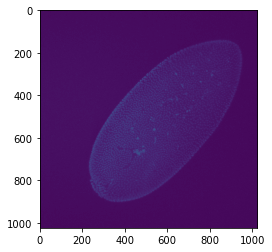

In [4]:
czi = czifile.imread(filename)
img=czi.squeeze()
data = {}
for channel in channel_list:
    data[channel] = img[channel_dict[channel],...]
    
xdim = img.shape[2]
ydim = img.shape[3]
z_plane = img.shape[1]/2
z_plane = round(z_plane)

max_AP = data[ap_channel].max(0) # this will be how to pick AP axis
# zshape = data[shape_channel][z_plane,:,:]
zshape = data[shape_channel].max(0)

#zshape = exposure.adjust_gamma(zshape)
plt.imshow(zshape)


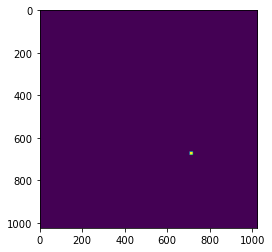

In [5]:
## THRESHOLD OHTSU
zshape = data[shape_channel].max(0)
    #make the mask of the embryo shape
# zshape = exposure.adjust_gamma(zshape)
# fig, ax = filters.try_all_threshold(zshape, figsize=(16,10))
bkgd = filters.threshold_otsu(zshape) #np.nanquantile(zshape.flatten(), 0.75)
#print(f'bkgd = {bkgd}')
max_signal = np.max(zshape)-1#np.quantile(zshape, 0.7)
#print(f'top = {top}')
zshape = filters.apply_hysteresis_threshold(zshape, bkgd, max_signal) # I need to do another threshold here. 
#zshape = filters.threshold_sauvola(zshape)#,r=bkgd)
zshape = filters.threshold_sauvola(zshape)#,r=bkgd)
zshape = morphology.binary_closing(zshape)
# # zshape = filters.apply_hysteresis_threshold(zshape, bkgd_signal, np.max(zshape)-1) # I need to do another threshold here. 
#zshape = morphology.flood(zshape)
# #zshape_edge = canny(zshape, sigma=2.0, low_threshold=0.55, high_threshold=0.8) 

plt.imshow(zshape)
# zshape.shape

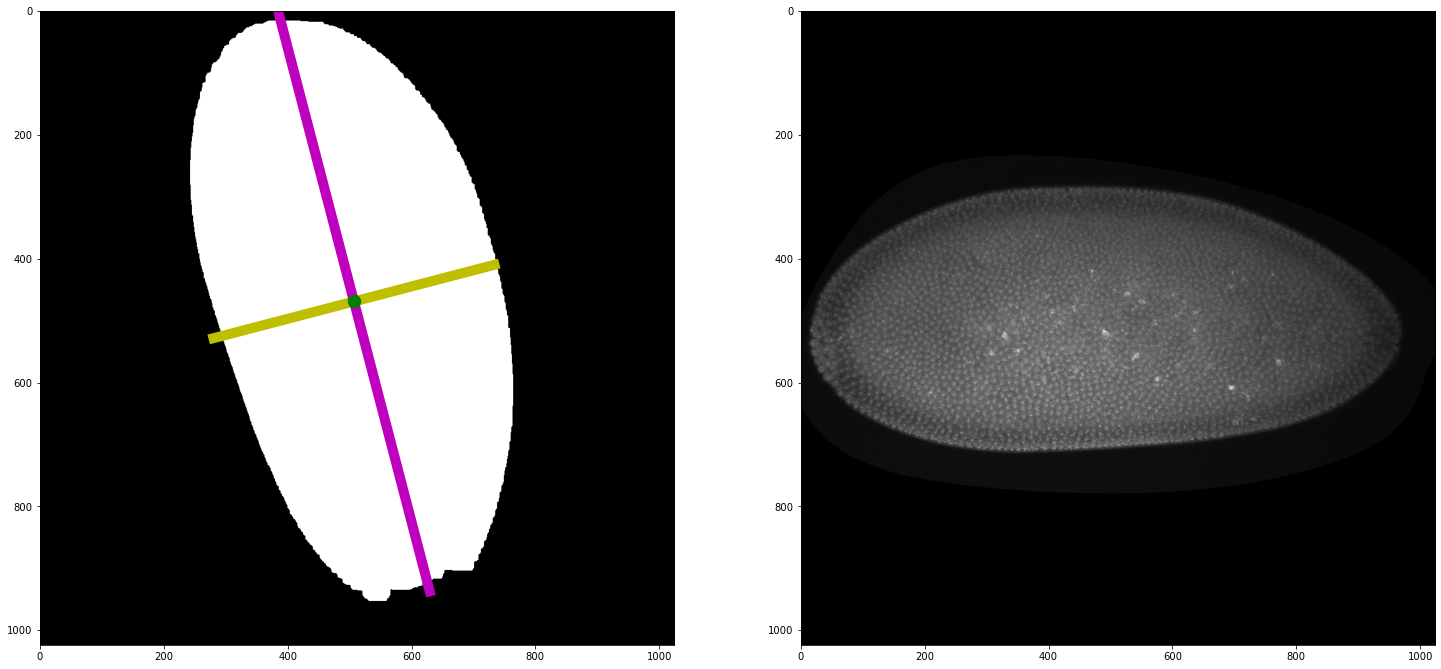

In [19]:

#get_dimensions
emb_label= label(zshape.astype(np.uint8))
emb_regions = regionprops(zshape.astype(np.uint8))

for props in emb_regions:
    y0, x0 = props.centroid
    orientation = props.orientation
    long_axis = props.major_axis_length
    short_axis = props.minor_axis_length
    minr, minc, maxr, maxc = props.bbox

    x1 = x0 + math.cos(orientation) * 0.5 * props.minor_axis_length #top
    y1 = y0 - math.sin(orientation) * 0.5 * props.minor_axis_length
    x3 = x0 - math.cos(orientation) * 0.5 * props.minor_axis_length #bottom
    y3 = y0 + math.sin(orientation) * 0.5 * props.minor_axis_length
        
    x2 = x0 - math.sin(orientation) * 0.5 * props.major_axis_length
    y2 = y0 - math.cos(orientation) * 0.5 * props.major_axis_length
    x4 = x0 + math.sin(orientation) * 0.5 * props.major_axis_length
    y4 = y0 + math.cos(orientation) * 0.5 * props.major_axis_length

rotation_axis = 90 - (orientation * 180/math.pi)
rotated_AP = ndimage.rotate(max_AP, rotation_axis)
rotated_AP = exposure.adjust_gamma(rotated_AP)

fig, ax = plt.subplots(1,2, figsize=(25,25))
ax[0].imshow(zshape, cmap=plt.cm.gray)
ax[0].plot((x3, x1), (y3, y1), '-y', linewidth=10) #minor axis line
ax[0].plot((x4, x2), (y4, y2), '-m', linewidth=10) #major axis line
ax[0].plot(x0, y0, '.g', markersize=25)

ax[1].imshow(rotated_AP, cmap=plt.cm.gray)

    #time to save
os.makedirs(path[:-4], exist_ok=True)
fig.savefig(os.path.join(path[:-4], f"{filename[:-4]}_APcheck"))

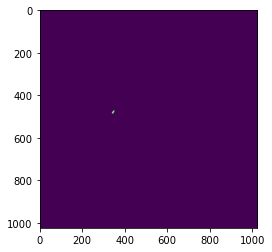

In [6]:
#THRESHOLD OPTION 2 
# GAMMA THRESHOLD
zshape = data[shape_channel][z_plane,:,:]

max_signal = np.max(zshape)-1#np.quantile(zshape, 0.7)
bkgd = 150
zshape = exposure.adjust_gamma(zshape)
zshape = filters.apply_hysteresis_threshold(zshape, bkgd_signal, max_signal)
zshape = morphology.binary_closing(zshape)

plt.imshow(zshape)
# zshape.shape

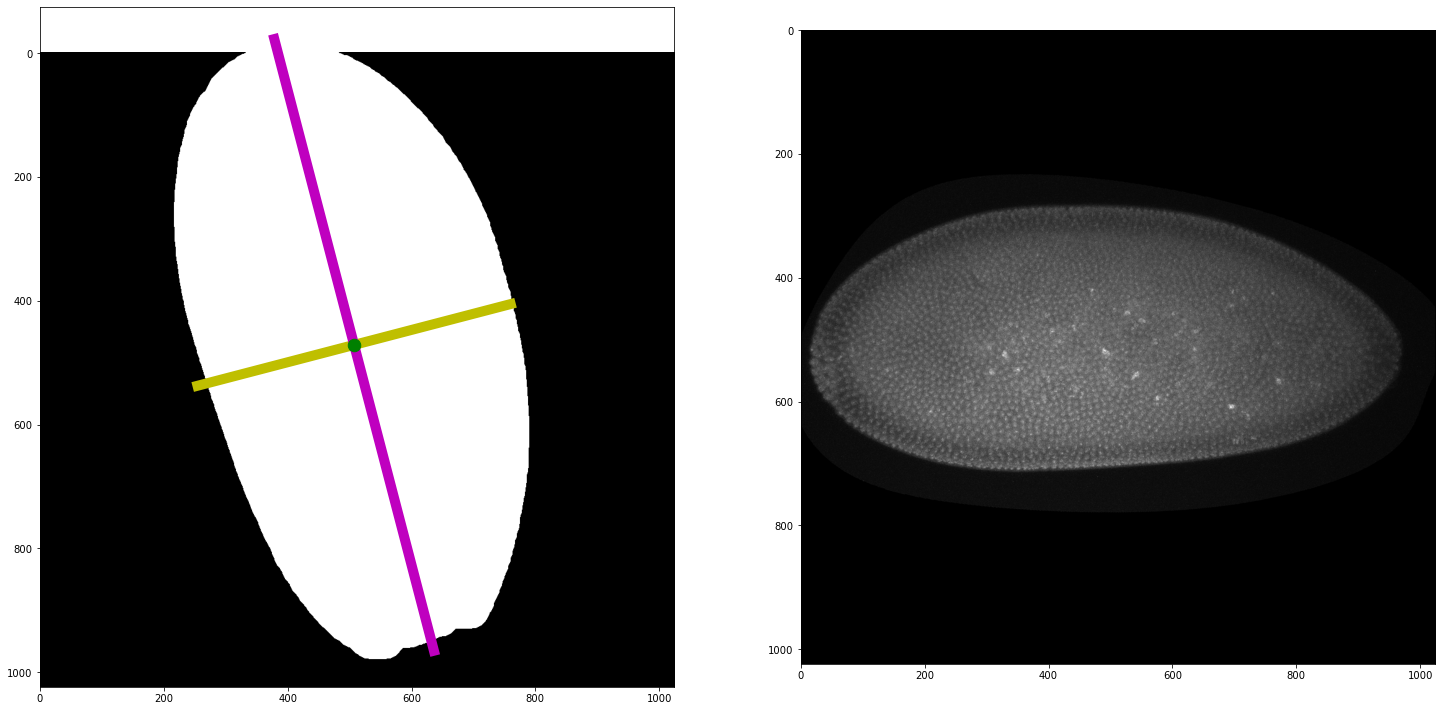

In [25]:

#get_dimensions
emb_label= label(zshape.astype(np.uint8))
emb_regions = regionprops(zshape.astype(np.uint8))

for props in emb_regions:
    y0, x0 = props.centroid
    orientation = props.orientation
    long_axis = props.major_axis_length
    short_axis = props.minor_axis_length
    minr, minc, maxr, maxc = props.bbox

    x1 = x0 + math.cos(orientation) * 0.5 * props.minor_axis_length #top
    y1 = y0 - math.sin(orientation) * 0.5 * props.minor_axis_length
    x3 = x0 - math.cos(orientation) * 0.5 * props.minor_axis_length #bottom
    y3 = y0 + math.sin(orientation) * 0.5 * props.minor_axis_length
        
    x2 = x0 - math.sin(orientation) * 0.5 * props.major_axis_length
    y2 = y0 - math.cos(orientation) * 0.5 * props.major_axis_length
    x4 = x0 + math.sin(orientation) * 0.5 * props.major_axis_length
    y4 = y0 + math.cos(orientation) * 0.5 * props.major_axis_length

rotation_axis = 90 - (orientation * 180/math.pi)
rotated_AP = ndimage.rotate(max_AP, rotation_axis)
rotated_AP = exposure.adjust_gamma(rotated_AP)

fig, ax = plt.subplots(1,2, figsize=(25,25))
ax[0].imshow(zshape, cmap=plt.cm.gray)
ax[0].plot((x3, x1), (y3, y1), '-y', linewidth=10) #minor axis line
ax[0].plot((x4, x2), (y4, y2), '-m', linewidth=10) #major axis line
ax[0].plot(x0, y0, '.g', markersize=25)

ax[1].imshow(rotated_AP, cmap=plt.cm.gray)

    #time to save
os.makedirs(path[:-4], exist_ok=True)
fig.savefig(os.path.join(path[:-4], f"{filename[:-4]}_APcheck"))

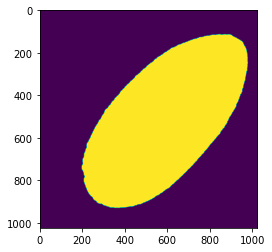

In [12]:
## THRESHOLD DILATION
zshape = data[shape_channel].max(0)
    #make the mask of the embryo shape
zshape = exposure.adjust_gamma(zshape)
# fig, ax = filters.try_all_threshold(zshape, figsize=(16,10))
#bkgd = filters.threshold_otsu(zshape) #np.nanquantile(zshape.flatten(), 0.75)
bkgd = 200
max_signal = np.max(zshape)-1#np.quantile(zshape, 0.7) 
#zshape = filters.threshold_sauvola(zshape)#,r=bkgd)
zshape = filters.apply_hysteresis_threshold(zshape, bkgd, max_signal)
#zshape = morphology.binary_closing(zshape)
footprint=morphology.disk(25)
zshape = morphology.binary_dilation(zshape, footprint)

plt.imshow(zshape)
# zshape.shape

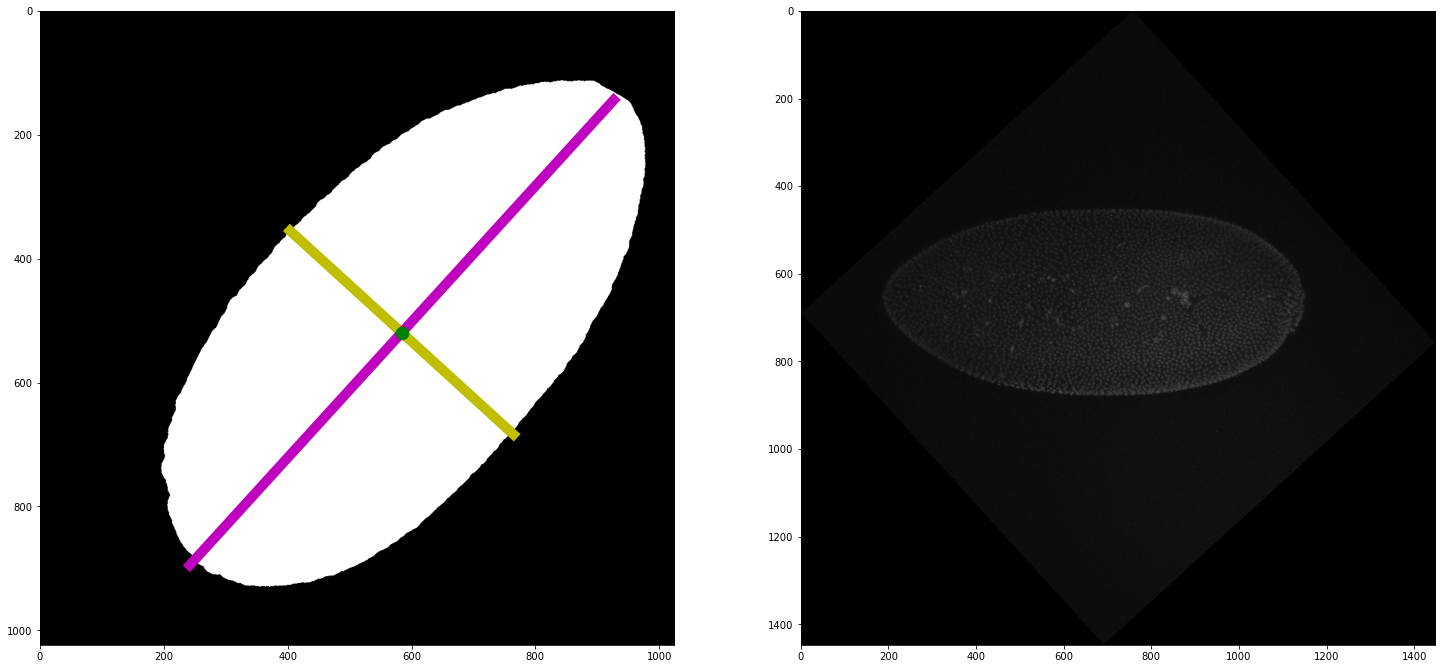

In [13]:
#get_dimensions
emb_label= label(zshape.astype(np.uint8))
emb_regions = regionprops(zshape.astype(np.uint8))

for props in emb_regions:
    y0, x0 = props.centroid
    orientation = props.orientation
    long_axis = props.major_axis_length
    short_axis = props.minor_axis_length
    minr, minc, maxr, maxc = props.bbox

    x1 = x0 + math.cos(orientation) * 0.5 * props.minor_axis_length #top
    y1 = y0 - math.sin(orientation) * 0.5 * props.minor_axis_length
    x3 = x0 - math.cos(orientation) * 0.5 * props.minor_axis_length #bottom
    y3 = y0 + math.sin(orientation) * 0.5 * props.minor_axis_length
        
    x2 = x0 - math.sin(orientation) * 0.5 * props.major_axis_length
    y2 = y0 - math.cos(orientation) * 0.5 * props.major_axis_length
    x4 = x0 + math.sin(orientation) * 0.5 * props.major_axis_length
    y4 = y0 + math.cos(orientation) * 0.5 * props.major_axis_length

rotation_axis = 90 - (orientation * 180/math.pi)
rotated_AP = ndimage.rotate(max_AP, rotation_axis)
rotated_AP = exposure.adjust_gamma(rotated_AP)

fig, ax = plt.subplots(1,2, figsize=(25,25))
ax[0].imshow(zshape, cmap=plt.cm.gray)
ax[0].plot((x3, x1), (y3, y1), '-y', linewidth=10) #minor axis line
ax[0].plot((x4, x2), (y4, y2), '-m', linewidth=10) #major axis line
ax[0].plot(x0, y0, '.g', markersize=25)

ax[1].imshow(rotated_AP, cmap=plt.cm.gray)

    #time to save
os.makedirs(path[:-4], exist_ok=True)
fig.savefig(os.path.join(path[:-4], f"{filename[:-4]}_APcheck"))